In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split, KFold, GroupKFold, BaseCrossValidator, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import ClassifierMixin
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

We start importing the data set to study the different columns relevance.

In [2]:
raw_data = pd.read_csv("dataset.csv")
raw_data.head(5)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


# Relevance of all variables: 

id: Unique identifier for each respondent; irrelevant for analysis (can be dropped).

Gender: Helps identify gender-based trends or disparities in depression levels.

Age: Relevant for analyzing how depression correlates with age.

City: Useful for identifying regional patterns in mental health.

Profession: Captures the impact of professional status (e.g., being a student) on depression.

Academic Pressure: Key to understanding the role of academic stress in mental health.

Work Pressure: Helps analyze how work-related stress impacts depression.

CGPA: Reflects academic performance, which may correlate with mental health.

Study Satisfaction: Indicates how satisfaction with studies influences depression.

Job Satisfaction: Relevant for understanding the impact of job fulfillment on mental well-being.

Sleep Duration: Critical for exploring the relationship between sleep habits and mental health.

Dietary Habits: Highlights how diet quality affects mental health.

Degree: Useful for analyzing mental health trends across different education levels.

Have you ever had suicidal thoughts?: Directly related to understanding extreme mental health risks.

Work/Study Hours: Reflects the impact of workload on mental health.

Financial Stress: Important for evaluating the role of financial factors in mental health.

Family History of Mental Illness: Crucial for understanding genetic or familial influences on depression.

Depression: The target variable for predictive analysis.

# Handling Missing Values

In [3]:
# Delete id column
raw_data.drop(columns=['id'], axis=1, inplace=True)

# Check missing values
missing_values = raw_data.isnull().sum()
missing_values

Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

We see that the missing values exclusively are in the financial Stress column. We replace these 3 missing values by median of the whole datasets Financial Stress values.

In [4]:
financial_stress_median = raw_data['Financial Stress'].median()
raw_data['Financial Stress'].fillna(financial_stress_median, inplace=True)

/tmp/ipykernel_2049645/2780200284.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data['Financial Stress'].fillna(financial_stress_median, inplace=True)


Since it's a survey, we ensure that all the "yes" and "no" are standardized, are typed in lowercase in our case.

In [5]:
raw_data['Have you ever had suicidal thoughts ?'] = raw_data['Have you ever had suicidal thoughts ?'].str.strip().str.lower()
raw_data['Family History of Mental Illness'] = raw_data['Family History of Mental Illness'].str.strip().str.lower()


Converting categorical Sleep Duration values (e.g., "5-6 hours", "Less than 5 hours") into numerical representations based on estimated averages.

In [6]:
def transform_sleep_duration(duration):
    if "less than 5" in duration.lower():
        return 4.5
    elif "5-6" in duration.lower():
        return 5.5
    elif "7-8" in duration.lower():
        return 7.5
    elif "more than 8" in duration.lower():
        return 9.0
    else:
        return None 

raw_data['Sleep Duration'] = raw_data['Sleep Duration'].apply(transform_sleep_duration)

In [7]:
# Check cities
def check_count(var:str):
    total = raw_data.groupby(var).count()['Depression']
    print(total[total < max(total)/100])
    print(f'\nNumber of entries with a low number of values for {var}: {total[total < max(total)/100].sum()}\n')
    print('\n\n============================================================\n\n')
    unreal_cities = list(total[total < max(total)/100].keys())
    return unreal_cities

In [8]:
unreal_cities = check_count('City')
under_rep_age = check_count('Age')
under_rep_job_statisfaction = check_count('Job Satisfaction')
under_rep_job = check_count('Profession')
under_rep_degree = check_count('Degree')

City
3.0                   1
Bhavna                2
City                  2
Gaurav                1
Harsh                 1
Harsha                2
Khaziabad             1
Kibara                1
Less Delhi            1
Less than 5 Kalyan    1
M.Com                 1
M.Tech                1
ME                    1
Mihir                 1
Mira                  1
Nalini                1
Nalyan                1
Nandini               1
Rashi                 1
Reyansh               1
Saanvi                2
Vaanya                1
Name: Depression, dtype: int64

Number of entries with a low number of values for City: 26





Age
35.0    10
36.0     7
37.0     2
38.0     8
39.0     3
41.0     1
42.0     4
43.0     2
44.0     1
46.0     2
48.0     3
49.0     1
51.0     1
54.0     1
56.0     1
58.0     1
59.0     1
Name: Depression, dtype: int64

Number of entries with a low number of values for Age: 49





Job Satisfaction
1.0    2
2.0    3
3.0    1
4.0    2
Name: Depression, dtype: int64



In [12]:
raw_data = raw_data[~raw_data['City'].isin(unreal_cities)]
Age_data = raw_data[~raw_data['Age'].isin(under_rep_age)]

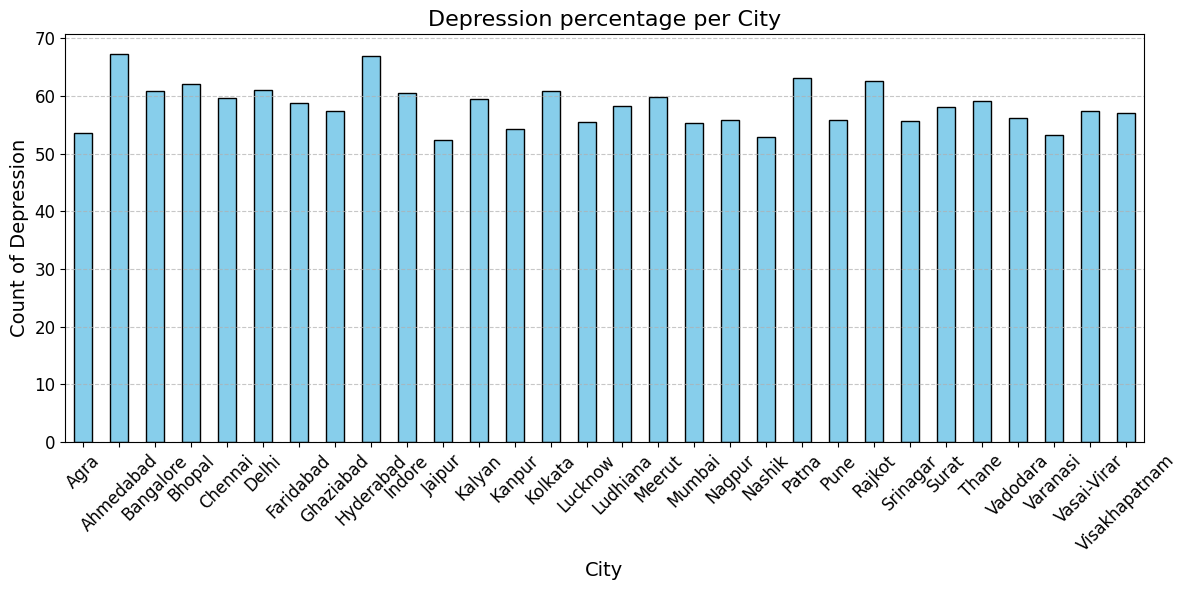

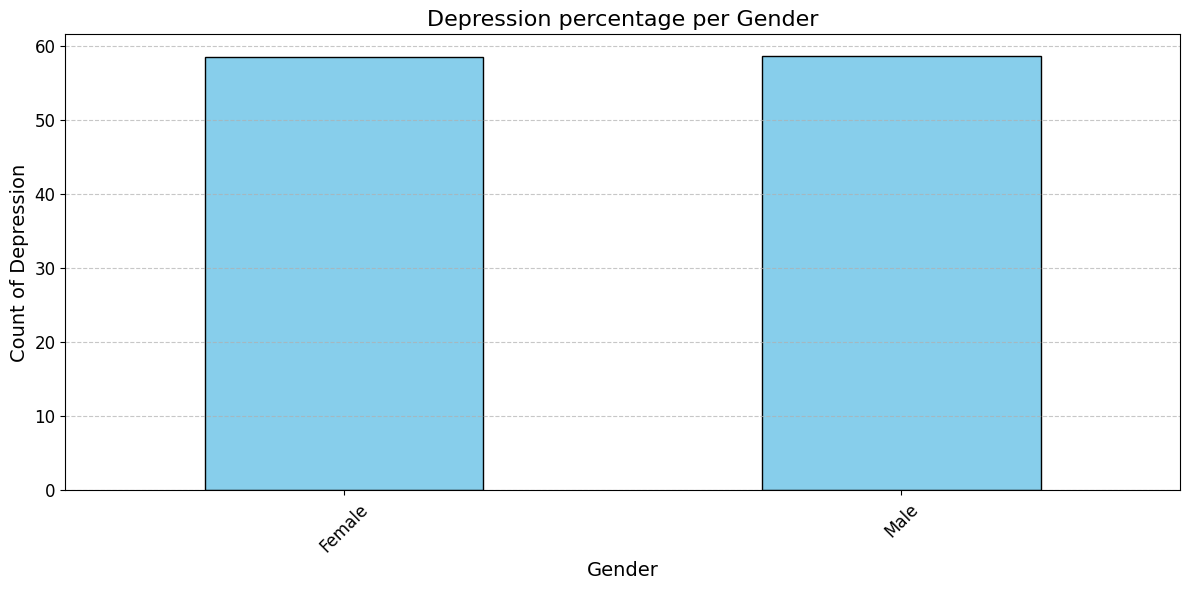

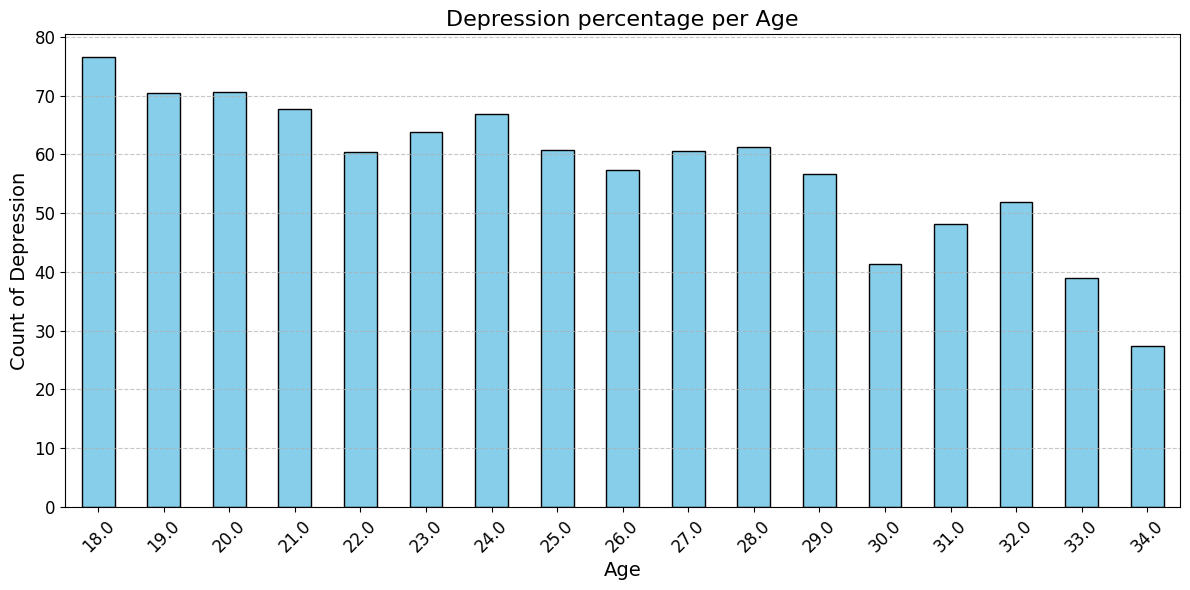

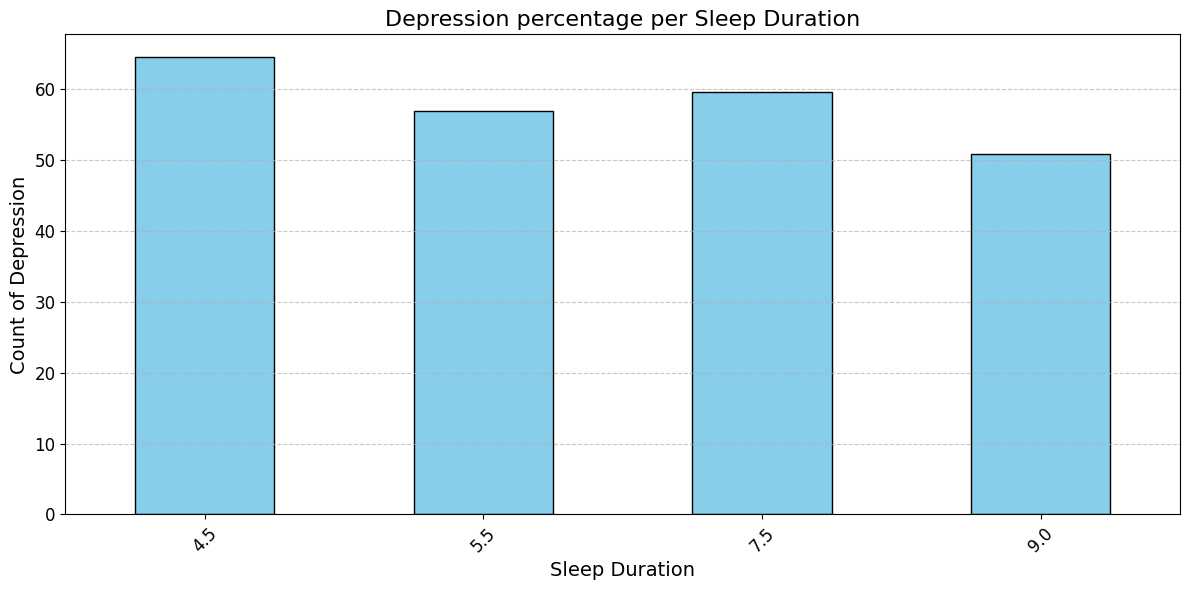

In [13]:
def percent_depression(var:str, data:pd.DataFrame):
    """
    Function to calculate the percentage of depression based on a specified variable in a DataFrame.

    Args:
        var (str): The name of the column to analyze in the DataFrame.
        data (pd.DataFrame): The DataFrame containing the data to analyze.

    Returns:
        float: The percentage of depression in the specified column.
    """
    total = data.groupby(var).count()['Depression']
    counts = data[data['Depression'] == 1].groupby(var)['Depression'].count()
    percentage = (counts / total) * 100

    plt.figure(figsize=(12, 6))
    percentage.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Depression percentage per {var}", fontsize=16)
    plt.xlabel(f"{var}", fontsize=14)
    plt.ylabel("Count of Depression", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

percent_depression('City', data=raw_data)
percent_depression('Gender', data=raw_data)
percent_depression('Age', data=Age_data)
percent_depression('Sleep Duration', data=raw_data)

In [25]:
# didn't find beter data to classify climate of cities in india. Climate is unknown for 21 cities.

climate_df = pd.read_csv('data_climate.csv')
merged_df = pd.merge(raw_data, climate_df, on="City", how="left")
len(merged_df[merged_df['Koppen Code'].isna()]['City'].unique())

21

Categorical variables (e.g., "Gender", "City") contain values that are textual or non-numeric (e.g., "Male", "Female"). Most machine learning models require numeric input, so these variables need to be converted into a numerical format. One-hot encoding is one method to achieve this.

In [34]:
categorical_columns = ['Gender', 'Profession', 'Dietary Habits', 'Degree'] #, 'City'
data = pd.get_dummies(raw_data, columns=categorical_columns, drop_first=True)

The target variable Depression has values 0 and 1, representing "No" and "Yes" states, respectively. Converting it into a categorical type makes it explicitly clear that this is not a continuous variable but rather a binary classification

In [35]:
data['Depression'] = data['Depression'].astype('category')

<Figure size 1400x800 with 0 Axes>

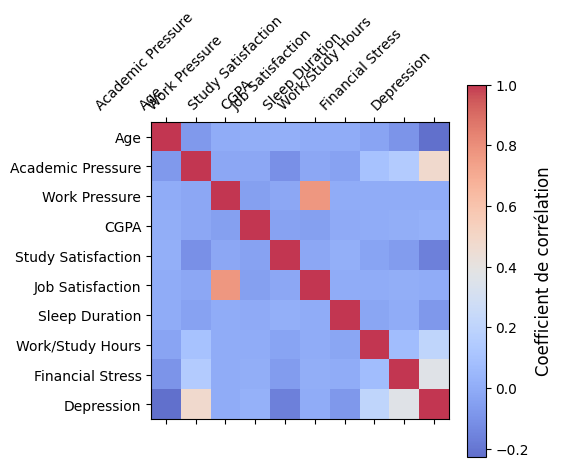

In [36]:
def numeric_columns(df):
    """
    Function to get numeric columns.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
    """
    numeric_columns = df.select_dtypes(include=["number"]).columns

    return list(numeric_columns)

cols = numeric_columns(data)
cols.extend(['Depression'])
df_numeric = data[cols]
corr = df_numeric.corr()

plt.figure(figsize=(14, 8))
plt.matshow(corr, cmap='coolwarm', alpha=0.8)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, fontsize=10, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=10)
cbar = plt.colorbar()
cbar.set_label('Coefficient de corrélation', fontsize=12)
plt.show()

In [ ]:
# Convert target variable to numeric
y = data['Depression'].map({0: 0, 1: 1})  # Assuming binary

# Drop target column
X = data.drop(columns=['Depression'])

X['Have you ever had suicidal thoughts ?'] = X['Have you ever had suicidal thoughts ?'].map({'yes': 1, 'no': 0})
X['Family History of Mental Illness'] = X['Family History of Mental Illness'].map({'yes': 1, 'no': 0})

# Handle missing values
X.fillna(X.median(), inplace=True)  # Replace missing numerical values with median
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Age                                      24.024864
Academic Pressure                         1.904729
Work Pressure                             0.002419
CGPA                                      2.168560
Study Satisfaction                        1.853050
Job Satisfaction                          0.002464
Sleep Duration                            3.032577
Have you ever had suicidal thoughts ?     0.231897
Work/Study Hours                         13.779312
Financial Stress                          2.068472
Family History of Mental Illness          0.249783
Gender_Male                               0.246608
Profession_Chef                           0.000000
Profession_Civil Engineer                 0.000045
Profession_Content Writer                 0.000045
Profession_Digital Marketer               0.000134
Profession_Doctor                         0.000090
Profession_Educational Consultant         0.000000
Profession_Entrepreneur                   0.000045
Profession_Lawyer              

In [39]:
def asses_model(estimator:ClassifierMixin): 
    """
    Function to fit, predict and asses model.
    """
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    scores = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {scores}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

def model_selection(estimator:ClassifierMixin, cv:BaseCrossValidator|None = None, param_grid:dict = {}):
    """
    Function to help for model selection with cross-validation like methods and grid search
    """
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                            cv=cv, n_jobs=-1, verbose=0, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    #print(grid_search.cv_results_)
    print("best parameters : ", grid_search.best_params_)

    return best_model

def standardize_columns(df, columns):
    """
    Standardize specified columns in a DataFrame using their mean and standard deviation.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to standardize.

    Returns:
        pd.DataFrame: A copy of the DataFrame with the specified columns standardized.
        dict: A dictionary containing the mean and standard deviation for each standardized column.
    """
    scaler = StandardScaler()
    df_copy = df.copy()
    df_copy[columns] = scaler.fit_transform(df[columns])
    stats = {
        col: {"mean": scaler.mean_[i], "std": scaler.scale_[i]} 
        for i, col in enumerate(columns)
    }
    return df_copy, stats

def standardize_test_data(df, columns, stats):
    """
    Standardize specified columns in a test DataFrame using the provided mean and standard deviation.

    Args:
        df (pd.DataFrame): The test DataFrame to be standardized.
        columns (list): A list of column names to standardize.
        stats (dict): A dictionary containing the mean and standard deviation for each column 
                      (from the training dataset).

    Returns:
        pd.DataFrame: A copy of the test DataFrame with the specified columns standardized.
    """
    df_copy = df.copy()
    for col in columns:
        if col not in stats:
            raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
        if col not in df_copy.columns:
            raise ValueError(f"Column '{col}' not found in the test DataFrame.")
        
        mean = stats[col]["mean"]
        std = stats[col]["std"]
        
        df_copy[col] = (df_copy[col] - mean) / std

    return df_copy

In [44]:
# Standardize numeric columns and save means and std

col_names = numeric_columns(X_train)
X_train, param_stand = standardize_columns(X_train, col_names)
X_test = standardize_test_data(X_test, col_names, param_stand)
stats = pd.DataFrame({
    'Mean': X_test.mean(),
    'Variance': X_test.var()
})
print(stats)

                                           Mean      Variance
Age                                    0.010042  1.008657e+00
Academic Pressure                     -0.022091  1.009590e+00
Work Pressure                         -0.010931  1.203922e-35
CGPA                                   0.028670  9.867010e-01
Study Satisfaction                     0.009123  9.992761e-01
Job Satisfaction                      -0.017151  1.203922e-35
Sleep Duration                        -0.016784  9.969452e-01
Have you ever had suicidal thoughts ? -0.018469  1.010164e+00
Work/Study Hours                       0.013810  9.882045e-01
Financial Stress                       0.004904  9.936148e-01
Family History of Mental Illness      -0.009406  9.995223e-01
Gender_Male                            0.552768  2.472598e-01
Profession_Chef                        0.000358  3.582945e-04
Profession_Civil Engineer              0.000000  0.000000e+00
Profession_Content Writer              0.000179  1.791794e-04
Professi

# Logistic regression

Let's try to strat with a logistic regression in order to predict depression cases. This choice is highly motivated by the interpretability of the approach.

In [88]:


# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=100, random_state=42, class_weight='balanced', verbose=0)
param_grid = {
    'penalty': ['l2', 'elasticnet', 'none', "l1"],
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 200, 300],
    'l1_ratio': [None, 0.1, 0.5, 0.9],  # ratio for combinaision of l1 and l2 in elasticnet
}
grid_logistic_model = model_selection(logistic_model, param_grid=param_grid)
asses_model(grid_logistic_model)


/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for a

best parameters :  {'C': 1, 'l1_ratio': None, 'max_iter': 200, 'penalty': 'l2'}
Accuracy: 0.8423318385650225

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2322
           1       0.87      0.85      0.86      3253

    accuracy                           0.84      5575
   macro avg       0.84      0.84      0.84      5575
weighted avg       0.84      0.84      0.84      5575



/home/ndubourg/Documents/Cours/Master2/supervised_learning/Projet/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The classification report indicates that the logistic regression model is performing reasonably well, achieving an overall accuracy of 79.79%. For the "Not Depressed" class (0), the model has a precision of 0.74, meaning 74% of the predictions for this class are correct. The recall for this class is 0.79, indicating that the model identifies 79% of the actual "Not Depressed" cases. The F1-score for this class is 0.77, showing a good balance between precision and recall.

For the "Depressed" class (1), the model performs slightly better, with a precision of 0.84, meaning 84% of predictions for this class are accurate. The recall is 0.80, showing that the model successfully identifies 80% of actual depression cases. The F1-score for this class is 0.82, reflecting a strong trade-off between precision and recall.

Overall, the macro and weighted averages for precision, recall, and F1-score are all approximately 0.80, suggesting that the model balances both classes effectively. These results indicate an improvement compared to the previous model, likely due to better handling of class imbalance or feature selection. However, further optimization or exploration of alternative models could improve the performance further, particularly in identifying the "Not Depressed" class more accurately.

# try random forest

In [89]:
random_forest_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50],  # Number of trees
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],  # Nombre minimal d'échantillons nécessaires pour diviser un nœud
    'min_samples_leaf': [2, 4],  # Nombre minimal d'échantillons nécessaires dans un nœud terminal
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_samples': [None, 0.5, 0.8],  # if bootstrap = true
    'oob_score': [True],  # Out of bag error
}

grid_random_forest = model_selection(random_forest_model, param_grid=param_grid)
asses_model(random_forest_model)

best parameters :  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_samples': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'oob_score': True}
Accuracy: 0.836591928251121

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2322
           1       0.85      0.88      0.86      3253

    accuracy                           0.84      5575
   macro avg       0.83      0.83      0.83      5575
weighted avg       0.84      0.84      0.84      5575



In [27]:
# SVC_model = SVC()

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear'],  # Kernels , 'rbf', 'poly', 'sigmoid'
#     'degree': [2],  # for polynomial kernel
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
#     'coef0': [0.0, 0.1, 0.5],  # for poly and sigmoid
#     'tol': [1e-3, 1e-4],  # tolerance to stop algo
# }

# grid_SVC = model_selection(SVC_model, param_grid=param_grid)
# asses_model(SVC_model)

In [90]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan'],
}

grid_knn = model_selection(knn_model, param_grid=knn_param_grid)
asses_model(knn_model)

best parameters :  {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}
Accuracy: 0.7899551569506726

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      2322
           1       0.80      0.86      0.83      3253

    accuracy                           0.79      5575
   macro avg       0.79      0.78      0.78      5575
weighted avg       0.79      0.79      0.79      5575



In [28]:
kf = KFold(n_splits=10)
kk = GroupKFold(10)
type(kf)
type(kk)

sklearn.model_selection._split.GroupKFold

# Deep learning

We don't obtain a good enouth results let's try deep learning.

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim

In [92]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers=3):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ) for _ in range(num_hidden_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.fc_out(x)
        x = self.sigmoid(x)
        
        return x


In [93]:
# Pandas dataframe to tensor
X_train_float = X_train.astype('float32')
X_test_float = X_test.astype('float32')
y_train_float = y_train.astype('float32')
y_test_float = y_test.astype('float32')

X_train_tensor = torch.tensor(X_train_float.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_float.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_float.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_float.values, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.size())
print(y_train_tensor.size())

torch.Size([22300, 55])
torch.Size([22300, 1])


In [99]:
# Parameters
input_size = 55
hidden_size = 32
learning_rate = 0.001
epochs = 2500

# Loss function and optimizer selection
model = SimpleNN(input_size, hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(epochs):
    optimizer.zero_grad() # Reinitialize gradient
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor) # Compute loss

    # Compute gradient and update coefficients
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/2500], Loss: 0.5536
Epoch [200/2500], Loss: 0.5440
Epoch [300/2500], Loss: 0.5434
Epoch [400/2500], Loss: 0.5432
Epoch [500/2500], Loss: 0.5431
Epoch [600/2500], Loss: 0.5431
Epoch [700/2500], Loss: 0.5430
Epoch [800/2500], Loss: 0.5430
Epoch [900/2500], Loss: 0.5429
Epoch [1000/2500], Loss: 0.5429
Epoch [1100/2500], Loss: 0.5428
Epoch [1200/2500], Loss: 0.5427
Epoch [1300/2500], Loss: 0.5427
Epoch [1400/2500], Loss: 0.5427
Epoch [1500/2500], Loss: 0.5426
Epoch [1600/2500], Loss: 0.5425
Epoch [1700/2500], Loss: 0.5425
Epoch [1800/2500], Loss: 0.5424
Epoch [1900/2500], Loss: 0.5423
Epoch [2000/2500], Loss: 0.5423
Epoch [2100/2500], Loss: 0.5422
Epoch [2200/2500], Loss: 0.5422
Epoch [2300/2500], Loss: 0.5421
Epoch [2400/2500], Loss: 0.5421
Epoch [2500/2500], Loss: 0.5420


### Evaluation Metrics

**1. Recall (Sensitivity, True Positive Rate):**

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

**2. Precision (Positive Predictive Value):**

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

**3. F1 Score (Harmonic Mean of Precision and Recall):**

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [100]:

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    predictions = model(X_test_tensor)  # Model output (logits)

# Apply threshold to get binary class predictions
predicted_classes = (predictions > 0.5).float()

# Convert tensors to NumPy arrays for compatibility with sklearn
y_true = y_test_tensor.numpy()
y_pred = predicted_classes.numpy()

# Generate the confusion matrix and other metrics
conf_matrix = confusion_matrix(y_true, y_pred)
precision = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
recall = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])
F1_score = 2 * (precision * recall / (precision + recall))
accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / sum(sum(conf_matrix))

print("Confusion Matrix:")
print(conf_matrix)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {F1_score}")
print(f"Accuracy: {accuracy}")


Confusion Matrix:
[[1957  365]
 [ 558 2695]]
Recall: 0.8284660313556717
Precision: 0.880718954248366
F1-score: 0.8537937589101853
Accuracy: 0.8344394618834081
